<a href="https://colab.research.google.com/github/susanesho/lung-cancer-project/blob/main/Lung_Cancer_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CS651 Project: Lung Cancer Prediction

Resources:
https://towardsdatascience.com/your-first-apache-spark-ml-model-d2bb82b599dd

In [ ]:
# Install Pyspark: Python API of Spark
!pip3 install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 19.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=9f4680d5be81acd1f27db5bfc746b312a2345eaf0e033b755fc569426c18cf9c
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [ ]:
# Import libraries

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import isnull, when, count

from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### Load and Explore Dataset

In [ ]:
# Mount google drive which contains data

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Start spark session to load data

spark = SparkSession \
    .builder \
    .appName('Lung Cancer Project') \
    .getOrCreate()

In [ ]:
spark

In [ ]:
# Load data

file_path = "gdrive/MyDrive/Lungcancer1.csv"
cancer_df = (spark.read
          .format("csv")
          .option("encoding", "UTF-8")
          .option('header', 'true')
          .load(file_path))

#cancer_df = spark.read.csv("gdrive/MyDrive/Lungcancer.csv")

In [ ]:
cancer_df.toPandas()

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,P1,33,1,2,4,5,4,3,2,2,...,3,4,2,2,3,1,2,3,4,Low
1,P10,17,1,3,1,5,3,4,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,P100,35,1,4,5,6,5,5,4,6,...,8,7,9,2,1,4,6,7,2,High
3,P1000,37,1,7,7,7,7,6,7,7,...,4,2,3,1,4,5,6,7,5,High
4,P101,46,1,6,8,7,7,7,6,7,...,3,2,4,1,4,2,4,2,3,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,P995,44,1,6,7,7,7,7,6,7,...,5,3,2,7,8,2,4,5,3,High
996,P996,37,2,6,8,7,7,7,6,7,...,9,6,5,7,2,4,3,1,4,High
997,P997,25,2,4,5,6,5,5,4,6,...,8,7,9,2,1,4,6,7,2,High
998,P998,18,2,6,8,7,7,7,6,7,...,3,2,4,1,4,2,4,2,3,High


In [ ]:
# Get number of instances
cancer_df.count()

1000

In [ ]:
# Check columns
cancer_df.columns

['Patient Id',
 'Age',
 'Gender',
 'Air Pollution',
 'Alcohol use',
 'Dust Allergy',
 'OccuPational Hazards',
 'Genetic Risk',
 'chronic Lung Disease',
 'Balanced Diet',
 'Obesity',
 'Smoking',
 'Passive Smoker',
 'Chest Pain',
 'Coughing of Blood',
 'Fatigue',
 'Weight Loss',
 'Shortness of Breath',
 'Wheezing',
 'Swallowing Difficulty',
 'Clubbing of Finger Nails',
 'Frequent Cold',
 'Dry Cough',
 'Snoring',
 'Level']

In [ ]:
# Check statistics of features

cancer_df.describe().toPandas()

,summary,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,count,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
1,mean,None,37.174,1.402,3.84,4.563,5.165,4.84,4.58,4.38,...,3.856,3.855,4.24,3.777,3.746,3.923,3.536,3.853,2.926,None
2,stddev,None,12.00549273690405,0.4905472827736759,2.0303995967598407,2.620476654713393,1.9808328295690911,2.107805219379352,2.126998853813542,1.8485175187206142,...,2.2446162928888995,2.206545681340823,2.2850867864528954,2.0419207723220905,2.270382927754401,2.3880481096020167,1.8325015858279798,2.0390067553955165,1.4746859661292964,None
3,min,P1,14,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,High
4,max,P999,73,2,8,8,8,8,7,7,...,9,8,9,8,8,9,7,7,7,Medium


In [ ]:
# Check datatypes of columns
cancer_df.dtypes

[('Patient Id', 'string'),
 ('Age', 'string'),
 ('Gender', 'string'),
 ('Air Pollution', 'string'),
 ('Alcohol use', 'string'),
 ('Dust Allergy', 'string'),
 ('OccuPational Hazards', 'string'),
 ('Genetic Risk', 'string'),
 ('chronic Lung Disease', 'string'),
 ('Balanced Diet', 'string'),
 ('Obesity', 'string'),
 ('Smoking', 'string'),
 ('Passive Smoker', 'string'),
 ('Chest Pain', 'string'),
 ('Coughing of Blood', 'string'),
 ('Fatigue', 'string'),
 ('Weight Loss', 'string'),
 ('Shortness of Breath', 'string'),
 ('Wheezing', 'string'),
 ('Swallowing Difficulty', 'string'),
 ('Clubbing of Finger Nails', 'string'),
 ('Frequent Cold', 'string'),
 ('Dry Cough', 'string'),
 ('Snoring', 'string'),
 ('Level', 'string')]

<Axes: xlabel='Level'>

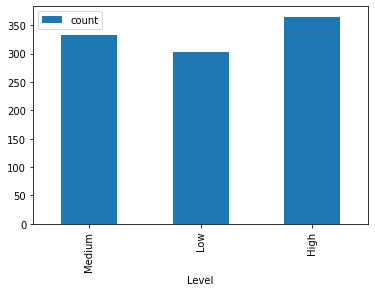

In [ ]:
# Visualize distribution of Lung Cancer level

cancer_level = cancer_df.groupBy("Level").count().sort("Level", ascending=False)
cancer_level.toPandas().plot.bar(x='Level',figsize=(6, 4))

### Data preparation and feature engineering

In [ ]:
# Change Patient ID to just numerical (P23 -> 23)

cancer_df = cancer_df.withColumn("Patient Id", regexp_replace("Patient Id", "P", ""))
cancer_df.toPandas().head()

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,1,33,1,2,4,5,4,3,2,2,...,3,4,2,2,3,1,2,3,4,Low
1,10,17,1,3,1,5,3,4,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,100,35,1,4,5,6,5,5,4,6,...,8,7,9,2,1,4,6,7,2,High
3,1000,37,1,7,7,7,7,6,7,7,...,4,2,3,1,4,5,6,7,5,High
4,101,46,1,6,8,7,7,7,6,7,...,3,2,4,1,4,2,4,2,3,High


In [ ]:
# Convert columns with String types to float (except Patient Id and Level)

string_columns = ["Level"]
cancer_df = cancer_df.select(
    *(col(c).cast("float").alias(c) for c in cancer_df.columns if c not in string_columns),
    col("Level"))

In [ ]:
cancer_df.dtypes

In [ ]:
# Check for null values 

cancer_df.select([count(when(isnull(c), c)).alias(c) for c in 
                  cancer_df.columns]).show()

# No null values, so we can proceed

+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+-----+
|Patient Id|Age|Gender|Air Pollution|Alcohol use|Dust Allergy|OccuPational Hazards|Genetic Risk|chronic Lung Disease|Balanced Diet|Obesity|Smoking|Passive Smoker|Chest Pain|Coughing of Blood|Fatigue|Weight Loss|Shortness of Breath|Wheezing|Swallowing Difficulty|Clubbing of Finger Nails|Frequent Cold|Dry Cough|Snoring|Level|
+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+-----+
|         0|  0|     0

In [ ]:
# Encode categorical (string type) column ( i.e Level)

cancer_df = StringIndexer(
    inputCol='Level', 
    outputCol='Level_encoded', 
    handleInvalid='keep').fit(cancer_df).transform(cancer_df)

cancer_df.toPandas().head()

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level,Level_encoded
0,1.0,33.0,1.0,2.0,4.0,5.0,4.0,3.0,2.0,2.0,...,4.0,2.0,2.0,3.0,1.0,2.0,3.0,4.0,Low,2.0
1,10.0,17.0,1.0,3.0,1.0,5.0,3.0,4.0,2.0,2.0,...,3.0,7.0,8.0,6.0,2.0,1.0,7.0,2.0,Medium,1.0
2,100.0,35.0,1.0,4.0,5.0,6.0,5.0,5.0,4.0,6.0,...,7.0,9.0,2.0,1.0,4.0,6.0,7.0,2.0,High,0.0
3,1000.0,37.0,1.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,...,2.0,3.0,1.0,4.0,5.0,6.0,7.0,5.0,High,0.0
4,101.0,46.0,1.0,6.0,8.0,7.0,7.0,7.0,6.0,7.0,...,2.0,4.0,1.0,4.0,2.0,4.0,2.0,3.0,High,0.0


In [ ]:
# Drop columns we won't need
cancer_df2 = cancer_df.drop('Level')

In [ ]:
# Assemble training features with VectorAssembler

input_features = ['Age',
              'Gender',
              'Air Pollution',
              'Alcohol use',
              'Dust Allergy',
              'OccuPational Hazards',
              'Genetic Risk',
              'chronic Lung Disease',
              'Balanced Diet',
              'Obesity',
              'Smoking',
              'Passive Smoker',
              'Chest Pain',
              'Coughing of Blood',
              'Fatigue',
              'Weight Loss',
              'Shortness of Breath',
              'Wheezing',
              'Swallowing Difficulty',
              'Clubbing of Finger Nails',
              'Frequent Cold',
              'Dry Cough',
              'Snoring']

assembler = VectorAssembler(inputCols=input_features, outputCol='input_features')
transformed_data = assembler.transform(cancer_df2)

In [ ]:
transformed_data.toPandas().head(2)

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level_encoded,input_features
0,1.0,33.0,1.0,2.0,4.0,5.0,4.0,3.0,2.0,2.0,...,4.0,2.0,2.0,3.0,1.0,2.0,3.0,4.0,2.0,"[33.0, 1.0, 2.0, 4.0, 5.0, 4.0, 3.0, 2.0, 2.0,..."
1,10.0,17.0,1.0,3.0,1.0,5.0,3.0,4.0,2.0,2.0,...,3.0,7.0,8.0,6.0,2.0,1.0,7.0,2.0,1.0,"[17.0, 1.0, 3.0, 1.0, 5.0, 3.0, 4.0, 2.0, 2.0,..."


In [ ]:
# Split transformed data into training and test set
(training_data, test_data) = transformed_data.randomSplit([0.8,0.2])

### Model Training

In [ ]:
# We would use a Random Forest Classifier as a baseline

# Initialize model
rf_model = RandomForestClassifier(labelCol='Level_encoded', 
                            featuresCol='input_features',
                            maxDepth=1)

# Fit the model (train) -> Produces transformer
rf_model = rf_model.fit(training_data)

predictions = rf_model.transform(test_data)

In [ ]:
# Evaluate our model

# Initialize evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol='Level_encoded', #Change to cancerlevel
    predictionCol='prediction', 
    metricName='accuracy')

accuracy = evaluator.evaluate(predictions)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.8240740740740741


In [ ]:
predictions.toPandas().tail(3)

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level_encoded,input_features,rawPrediction,probability,prediction
213,993.0,37.0,2.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,...,4.0,5.0,6.0,7.0,5.0,0.0,"[37.0, 2.0, 7.0, 7.0, 7.0, 7.0, 6.0, 7.0, 7.0,...","[16.344344664316218, 3.2671658205093217, 0.388...","[0.8172172332158109, 0.1633582910254661, 0.019...",0.0
214,996.0,37.0,2.0,6.0,8.0,7.0,7.0,7.0,6.0,7.0,...,2.0,4.0,3.0,1.0,4.0,0.0,"[37.0, 2.0, 6.0, 8.0, 7.0, 7.0, 7.0, 6.0, 7.0,...","[16.344344664316218, 3.2671658205093217, 0.388...","[0.8172172332158109, 0.1633582910254661, 0.019...",0.0
215,999.0,47.0,1.0,6.0,5.0,6.0,5.0,5.0,4.0,6.0,...,1.0,4.0,6.0,7.0,2.0,0.0,"[47.0, 1.0, 6.0, 5.0, 6.0, 5.0, 5.0, 4.0, 6.0,...","[11.835865495740734, 5.808827034313805, 2.3553...","[0.5917932747870368, 0.2904413517156903, 0.117...",0.0
